<a href="https://colab.research.google.com/github/phyop/220505_TensorFlow2/blob/main/%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E9%A2%84%E6%B5%8B%E4%BB%BB%E5%8A%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/GoogleDrive_yaboaru/Colab Notebooks/220304_唐tensorflow2版本实战/第十二章：时间序列预测

/content/drive/MyDrive/GoogleDrive_yaboaru/Colab Notebooks/220304_唐tensorflow2版本实战/第十二章：时间序列预测


In [ ]:
ls

220428_2101_时间序列预测任务.ipynb  220503_1343_时间序列预测任务.ipynb
220429_1211_时间序列预测任务.ipynb  jena_climate_2009_2016.csv
220430_2228_时间序列预测任务.ipynb  时间序列预测任务.ipynb


## 时间序列预测任务

- 数据集：气温数据，多种指标
- 任务目标：预测未来某一时间点的气温/未来某一时间片段的气温


In [ ]:
# 之前的都是有標準答案的監督式學習，現在開始學回歸分析  

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# 不知道下面這個用在哪裡，應該就是從類似的應用copy過來
# 反正跑起來沒回報缺什麼套件，那就OK啦
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt # 大的先import，小的在後面去覆蓋大的
# jupyter notebook的魔術方法，用來對matplotlib畫圖的
%matplotlib inline 
import numpy as np
import os # 這個也不會用到，可能是別的ipynb會呼叫到本機的一些功能
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error  

# https://reurl.cc/XjkgRj
# Run at startup and they Configure your stuff.
mpl.rcParams['figure.figsize'] = (8, 6) # figure size in inches
mpl.rcParams['axes.grid'] = False # not display grid

In [ ]:
# from什麼
import tensorflow as tf
# dir(tf) # 看得到裡面有keras
# dir(len(tf)) # TypeError: object of type 'module' has no len()
# dir(type(tf)) # 從

# 意思是，目前會有
# import keras.metrics 
# 如果在import tensorflow as tf，接著寫from tf.keras import metrics
# 那就變成了from tensorflow.keras import metrics
# 因為因為前面已經有tf了，會出現No module named 'tf'的錯誤

In [ ]:
# csv讀進來之後，可以直接當做df
df = pd.read_csv('jena_climate_2009_2016.csv')
# 反正不知道內容的東西，不是print()，就head()
print(df.columns)
# Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'], dtype='object')
df.head()
# index	Date Time	p (mbar)	T (degC)	Tpot (K)	Tdew (degC)	rh (%)	VPmax (mbar)	VPact (mbar)	VPdef (mbar)	sh (g/kg)	H2OC (mmol/mol)	rho (g/m**3)	wv (m/s)	max. wv (m/s)	wd (deg)
# 0	01.01.2009 00:10:00	996.52	-8.02	265.4	-8.9	93.3	3.33	3.11	0.22	1.94	3.12	1307.75	1.03	1.75	152.3
# ...


Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
"""
1 to 5 of 5 entries
Filter

index	Date Time	p (mbar)	T (degC)	Tpot (K)	Tdew (degC)	rh (%)	VPmax (mbar)	VPact (mbar)	VPdef (mbar)	sh (g/kg)	H2OC (mmol/mol)	rho (g/m**3)	wv (m/s)	max. wv (m/s)	wd (deg)
0	01.01.2009 00:10:00	996.52	-8.02	265.4	-8.9	93.3	3.33	3.11	0.22	1.94	3.12	1307.75	1.03	1.75	152.3
1	01.01.2009 00:20:00	996.57	-8.41	265.01	-9.28	93.4	3.23	3.02	0.21	1.89	3.03	1309.8	0.72	1.5	136.1
2	01.01.2009 00:30:00	996.53	-8.51	264.91	-9.31	93.9	3.21	3.01	0.2	1.88	3.02	1310.24	0.19	0.63	171.6
3	01.01.2009 00:40:00	996.51	-8.31	265.12	-9.07	94.2	3.26	3.07	0.19	1.92	3.08	1309.19	0.34	0.5	198.0
4	01.01.2009 00:50:00	996.51	-8.27	265.15	-9.04	94.1	3.27	3.08	0.19	1.92	3.09	1309.0	0.32	0.63	214.3
Show 25 per page
Like what you see? Visit the data table notebook to learn more about interactive tables.
"""

'\n1 to 5 of 5 entries\nFilter\n\nindex\tDate Time\tp (mbar)\tT (degC)\tTpot (K)\tTdew (degC)\trh (%)\tVPmax (mbar)\tVPact (mbar)\tVPdef (mbar)\tsh (g/kg)\tH2OC (mmol/mol)\trho (g/m**3)\twv (m/s)\tmax. wv (m/s)\twd (deg)\n0\t01.01.2009 00:10:00\t996.52\t-8.02\t265.4\t-8.9\t93.3\t3.33\t3.11\t0.22\t1.94\t3.12\t1307.75\t1.03\t1.75\t152.3\n1\t01.01.2009 00:20:00\t996.57\t-8.41\t265.01\t-9.28\t93.4\t3.23\t3.02\t0.21\t1.89\t3.03\t1309.8\t0.72\t1.5\t136.1\n2\t01.01.2009 00:30:00\t996.53\t-8.51\t264.91\t-9.31\t93.9\t3.21\t3.01\t0.2\t1.88\t3.02\t1310.24\t0.19\t0.63\t171.6\n3\t01.01.2009 00:40:00\t996.51\t-8.31\t265.12\t-9.07\t94.2\t3.26\t3.07\t0.19\t1.92\t3.08\t1309.19\t0.34\t0.5\t198.0\n4\t01.01.2009 00:50:00\t996.51\t-8.27\t265.15\t-9.04\t94.1\t3.27\t3.08\t0.19\t1.92\t3.09\t1309.0\t0.32\t0.63\t214.3\nShow 25 per page\nLike what you see? Visit the data table notebook to learn more about interactive tables.\n'

每10分钟会记录一次，有多个指标

### 构建序列数据

- dataset表示输入的数据集，里面可以是一个或者多个列特征
- history_size表示时间窗口的大小：
- indices = range(i-history_size, i)表示窗口序列索引，i表示每个窗口的起始位置，即（0,0+history_size）（1，1+history_size）。。。
- target_size表示要预测的结果是窗口后的第几个时间点，0则表示下一时间点的预测结果，取其当做标签

In [ ]:
# 這邊是用於單特征的一元单变量univariate，後面會有用於多特征的multivariate 
# csv有各式各樣的特征，而這邊的dataset參數，指的是要用csv中的哪種特征當訓練data
# 從輸入的start_index位置，往後取history_size個元素位置，當做x
# 然後target_size，可以取x後的「一個位置」當y，也可以取x後的「一個片段」當y
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    # 要對單個特征的data，建立資料集(data, label)
    data = []
    labels = []

    # 原始輸入參數start_index，是指窗口的開始位置。這邊要修改成，是指窗口的結束位置。
    # 用原始輸入參數，原本理應是for i in range(start_index, end_index-history_size)
    # 但這樣在做每次迭代之前，都需要先做一次減法計算，當大量迭代的時候，就會消耗大量的計算資源
    # 如果可以把這個減法，移動到迭代的外部，那就只要做一次減法，節省大量資源
    # 2種方法，方法1是把end_index-history_size設為一個新變數，方法2是兩邊同時加上history_size
    # 方法1雖然把end_index-history_size設為一個新變數，讓新變數在for中做迭代，是一個好的數學解法，但物理上要解釋意義，好像比較困難
    # 方法2雖然兩邊同時加上history_size，看起來很白癡，只是把後面的減號問題，丟到前面變加號問題
    # 但方法2把兩邊都加上history_size，變成(start_index+history_size, end_index)
    # 去試著解釋起來的話，會發現兩邊都加上history_size，那相當於就是
    # start_index從原本第一個窗口的開始位置，順移了history_size，變成是指第一個窗口結束的右邊索引
    # 同理end_index也從原本最後一個窗口的開始位置，順移了history_size，變成是指最後一個窗口結束的右邊索引
    # 所以變成，for i in range(start_index + history_size, end_index)
    # 然後把然後再結合方法1，把start_index + history_size設成1個新變數
    # 法一法二到底對效率有沒有提升，可以藉由設定在for之前設t0，for之後設t1，去計算時間差求證
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    # 從第一個窗口結束的右邊索引，迭代到最後一個窗口結束的右邊索引
    # 對每一個窗口來說，窗口結束的右邊索引就是i。那起頭索引就是i-history_size
    # for i in range()的意義是，窗格一直步進右移
    for i in range(start_index, end_index):
        # 剛剛只是找出窗格的位置，實際要取得裡面的值才有用，也就是dataset[indices]
        # 因為輸入參數dataset，已經是從csv中過濾出需要的那個氣溫特征column
        # 所以dataset[indices]的意義就是，以每20個氣溫為一個窗格取出
        indices = range(i-history_size, i) # range(0, 20)，所以index=20的地方不會取到
        # 將1D結構，長度為history_size的dataset[indices]
        # 加上一個維度是1的dimension，reshape成2D
        # 特征從純量的shape(20,)，轉成多維的shape(20, 1)
        # 回想到之前RNN或進階版LSTM用的詞向量，特征都是多維的
        # 而這邊要用的是LSTM模型來訓練，所以特征也要仿照詞向量的多維，所以才reshape成多維
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        # 如果設0啊1的，就什麼也不會印出來，所以隨便抓一個大於20的數來看
        # 因為結尾index少於19的話，那長度就不足20
        """
        if i == 100: 
            print('dataset[indices].shape: ', dataset[indices].shape) # (20,)
            # data是list，所以不能用.shape
            print('len(data): ', len(data)) 
            # 81 = i-19。當結尾index在100的時候，代表長度滿足20且步長為1的窗格，加入了81個。
            print('dataset[indices]: ', dataset[indices]) 
            # [-1.7521994, ..., -1.68157074]，反正就是20個氣溫長度
            print('data: ', data) 
            # 81個array([[...]])，每個array裡面應該直接[裝有長度20的氣溫值]
            # 但因為reshape成(20, 1)，所以一個溫度就使用一個[]裝著，變成了[[溫度0],...,[溫度19]]
            # [array([[-1.99766294],..., [-1.68504428]]), 
            # array([[-1.7521994],..., [-1.68157074]])]
        """
        # 因為窗口結束的右邊索引是i，所以+0就是取窗格的右邊的那個位置
        labels.append(dataset[i+target_size])
        # 如果是取未來某個時間區段，那就是labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels) # 訓練用的資料，都用np格式

前30W个样本数据当做训练的，剩余的当做验证集

In [ ]:
# 全大寫，表示是一個常量
TRAIN_SPLIT = 300000 # 前30W个样本数据当做训练的，剩余的当做验证集
tf.random.set_seed(13) # 設好隨機種子，方便重現

### 单特征训练模型

In [ ]:
# 只选一个温度特征
uni_data = df['T (degC)'] # default會以0~N當index
# print(uni_data.shape) # (420551,)
# 0        -8.02
# 1        -8.41
#           ... 
# 420550   -4.82
# Name: T (degC), Length: 420551, dtype: float64
uni_data.index = df['Date Time'] # 指定uni_data這個df的index值
uni_data.head(3)
# Date Time
# 01.01.2009 00:10:00   -8.02
# 01.01.2009 00:20:00   -8.41
# 01.01.2009 00:30:00   -8.51
# Name: T (degC), dtype: float64

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
Name: T (degC), dtype: float64

展示当前特征

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa85044a850>],
      dtype=object)

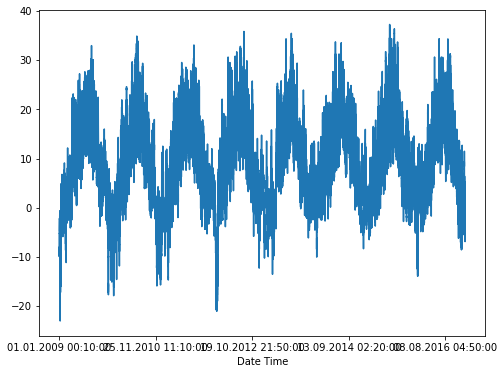

In [ ]:
# 用plot去視覺化觀察，看是不是有時間序列的關係
# 反正只要可以print的，就print，可以視覺化的，就視覺化
# 因為現在只有一個column，uni_data=df['T (degC)']
# 所以就算不設uni_data.index=df['Date Time']，也會自動給default的index值
# 所以x、y都有了，當然可以直接用df.plot()去畫出來
uni_data.plot(subplots=True)

In [ ]:
# 雖然uni_data = df['T (degC)']的shape也是(420551,)
# 但如果不使用.values去轉成array，那就會出現要傳入1-D的error了
uni_data = uni_data.values # array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])
# print(uni_data.shape) # (420551,)

### 数据预处理：标准化操作

In [ ]:
# 讓數據以原點0為中心，這樣比較方便看偏向哪邊多
# [0:TRAIN_SPLIT]，0可以省略
# 訓練集才需要做標準化
uni_train_mean = uni_data[:TRAIN_SPLIT].mean() # 算出訓練集的均值
# 讓數據標準差為1，控制波動範圍，才不需要放大縮小去看圖
uni_train_std = uni_data[:TRAIN_SPLIT].std() # 算出訓練集的標準差
# 訓練的過程中，都絕對不能用到驗證集、測試集
# 也就是標準化的操作，不需要對驗證集、測試集使用
uni_data = (uni_data-uni_train_mean)/uni_train_std

窗口大小为20条数据，预测一个时刻的气温

In [ ]:
univariate_past_history = 20 # 窗格長度為連續20天
# target_size=0的意思就是，取窗格右邊位置的溫度
univariate_future_target = 0

# 利用univariate_data()，去對原始資料集，過濾成(單變數的data, label)的資料集
# univariate_data(原始資料集, 起始index, 最後的index, 窗格長度, 標籤位於窗格右邊幾個位置):
# end_index是指最後一個窗口結束的右邊索引，也就是end_index是開放，start_index是閉合
# 前30W个样本数据当做训练，start_index=0, end_index=300000 
# 剩余的当做验证集，start_index=300000, end_index=None 
# 如果要指定end_index是到資料集的最後，那就是len(dataset) - target_size
# univariate_data()函數內才有去做變化
# 外面call的人還是把start_index、end_index，都分別當做窗格最左邊、最右邊那一個格子
# 雖然不用寫None，直接讓user寫 len(dataset) - target_size 也可以
# 不過為了讓user使用上不需要打那麼多code就可用，所以好的API可能就是連這個都要幫忙定義
# 一個時序資料集，而且是要做回歸分析，那重要的參數就是：窗格長度、label位置
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

数据与标签维度

In [ ]:
# 因為一個窗格要取20個，又限制到窗格只能走到索引是30萬為止，所以最後的20個無法取
# (dataset中多少個序列窗格, 一個序列窗格有多少個時間步長, 一個時間步長有多少個特征)
x_train_uni.shape # (299980, 20, 1)
y_train_uni.shape # (299980,)
# 代表單特征資料集的標籤y，只是「1個值而已」

(299980,)

训练特征X与标签Y

In [ ]:
print ('Single window of past history')
print (x_train_uni[0]) # 看一下實際數據內容長怎樣
# [[-1.99766294]
#  [-2.04281897]
#  ...
#  [-2.10418486]]
print ('\n Target temperature to predict')
print (y_train_uni[0])
# -2.1041848598100876

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [ ]:
"""
Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876
"""

'\nSingle window of past history\n[[-1.99766294]\n [-2.04281897]\n [-2.05439744]\n [-2.0312405 ]\n [-2.02660912]\n [-2.00113649]\n [-1.95134907]\n [-1.95134907]\n [-1.98492663]\n [-2.04513467]\n [-2.08334362]\n [-2.09723778]\n [-2.09376424]\n [-2.09144854]\n [-2.07176515]\n [-2.07176515]\n [-2.07639653]\n [-2.08913285]\n [-2.09260639]\n [-2.10418486]]\n\n Target temperature to predict\n-2.1041848598100876\n'

### 时间序列样本展示

In [ ]:
# 當下設爲時間0,所以歷史長度的數據，就要設爲負號時間，也就是range(-length, 0)
def create_time_steps(length):
    time_steps = []

    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

# 當遇到不太理解的function時，如果是短的就直接丟幾個參數去跑看看，然後觀察規律
# 如果function有點長的話，那就拆分成好幾個小部分，去歸類一下這些部分的作用各是什麼
# 看結果反正就是，把輸入參數取負號，然後一路到0,取range，放到list中
create_time_steps(8) # [-8, -7, -6, -5, -4, -3, -2, -1]

[-8, -7, -6, -5, -4, -3, -2, -1]

In [ ]:
# 上面的def其實用[i for i in range()]更簡潔
create_time_steps = lambda length:[i for i in range(-length, 0, 1)]
create_time_steps(8)

# https://openhome.cc/zh-tw/python/function/first-class/
# 如果 lambda 不需要參數，直接在 lambda 後加上冒號就可以了，若需要兩個以上的參數，中間要使用逗號。
# 相較於其他語言中的 lambda 語法，Python 使用 lambda 關鍵字的方式，其實並不簡潔，這是 Python 為了避免 lambda 造成可讀性不佳，而特意做的限制。

[-8, -7, -6, -5, -4, -3, -2, -1]

In [ ]:
# plot_data：歷史數據
# delta：未來回歸要預測的，的某個時間點或時間段
# title：圖名稱
def show_plot(plot_data, delta, title):
    # 觀察df.columns的輸出，發現這些lables不是原始資料的欄位名稱
    # 觀察輸出的圖例，可以發現做plot中的labels，指的是各條數據線的名稱
    labels = ['History', 'True Future', 'Model Prediction']
    # marker是點線的顏色、形狀
    # labels是各條數據線的名稱，所以當然是字串''。而marker的指定，也是字串''
    # marker的順序和labels要一致，在利用索引呼叫的時候，索引一致才方便識別
    marker = ['.-', 'rx', 'go']
    # 對create_time_steps點2下反白，只會秀出在同一個執行格內的同名，所以找不到在別的執行格的函數
    # x_train_uni.shape # 取dataset的整體shape，包括batch -> (batch, data.shape[0], data.shape[1]) -> (299980, 20, 1)
    # x_train_uni[0].shape # 對datasets的第0批次data，取shape -> (batch[0], 歷史數據長度, 未來預測長度) -> (20, 1) 
    # x_train_uni[0].shape[0] # 第0個batch數據，的第0個shape -> 歷史數據長度 -> 20
    time_steps = create_time_steps(plot_data[0].shape[0]) # 將歷史數據長度取負號直到0爲止當成x軸
    if delta: # 如果有指定未來回歸要預測的，的某個時間點或時間段
        future = delta
    # 既然create_time_steps()是range(-length, 0)，那就代表0是開放，-length是閉合。所以歷史數據不包含現在
    # 沒有指定的話，default就是預測當下氣溫
    # 所以做default，是寫API的人，要把事情做得更好的進階
    else: 
        future = 0

    plt.title(title)

    # 需要取元素的index，記得用enumerate
    # 有人家寫好現成的API就用，不需要傻傻的用土炮len(plot_data)去取索引
    # i：索引；x：元素。其實在這個for裡面沒有用到x，所以可以用_的變數去取代
    for i, x in enumerate(plot_data): 
        # 把else部分的code做注解掉，或是把if部分的code注解掉並把內容改成「None」，再去觀察輸出的圖，就知道是針對哪種數值的作圖了
        # 包括「'True Future'未來某時間的氣溫實際值」，以及「'Model Prediction'歷史記錄序列的平均值baseline」的繪圖設定
        if i: # 當i不爲0的時候，都套用
            # 因爲i=0是指定給歷史記錄，而其他的繪圖預計都放置各種預測值，所以x軸向的位置定義爲future變數
            # 預設x軸的值是「當前時間」，也就是x=0。但如果有給delta值，也就是自當前時間開始偏移幾個時間序，那就是採用輸入的引數delta當作x值
            """
            print('future', future) 
            # future 0
            # future 0
            print(f'plot_data[{i}]', plot_data[i])
            # plot_data[1] -2.1041848598100876
            # plot_data[2] -2.0479135001271396
            print()
            """
            # future在這邊是未來的某一個時間點，也就是一個單純的值而已
            # 而plot_data[1]是'True Future'未來某時間的氣溫實際值，也是一個單純的值而已
            # plot_data[2]是'Model Prediction'歷史記錄序列的平均值baseline，也是一個單純的值而已
            # 所以x、y軸的值數量是匹配的
            # 因爲是未來的預測值，是重要的點，所以markersize設大一點
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        
        else: # 當i=0的時候，也就是只針對labels[0]的「'History'歷史記錄序列」的繪圖
            # plt.plot(x, y, 'style')
            # plt.plot(將歷史數據長度取負號直到0爲止當成x軸, y軸是歷史數據)
            # plot_data[0]會回傳[-1.99766294]，shape是(1,)，感覺上就應該要做flatten()，降成一般np數值結構才袋子能計算、畫圖
            # 就算這個地方的數據，剛好實際上不做flatten()也可以，不過要畫圖或計算的話，做flatten()會比較通用，觀念上還是知道一下比較好
            # 觀察show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')畫的圖可以發現
            # show_plot([歷史記錄序列, 未來某時間的氣溫實際值, 歷史記錄序列的平均值baseline], 是要預測距離現在多少個的未來時間序, 圖名稱)
            # 首先，當一個參數有多個值要輸入時，那就用[]包起來傳進去
            # [歷史記錄序列, 未來某時間的氣溫實際值, 歷史記錄序列的平均值] -> ['History', 'True Future', 'Model Prediction']
            # x軸的time_steps是一個list，所以對應的y值plot_data[i]應該也要是一個list，
            # print('time_steps', time_steps) # [-20, -19, ..., -1]
            # f'plot_data[{i}]'
            # 'plot_data[{}]'.format(i)
            # 'plot_data[%d]'%(i)
            """
            print(f'plot_data[{i}]', plot_data[i]) 
            # plot_data[0] [[-1.99766294]...[-2.10418486]]
            print()
            """
            # 如果plot_data參數的輸入，是一個具有3個元素的list，那麼plot_data[0]指的就會是plot_data這個引數的第0個值，也就是x_train_uni[0]
            # 而x_train_uni[0]的是一個長度20的list，所以當作y的話，和x軸也是list的time_steps，值數量長度是匹配一致的
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    # https://blog.csdn.net/helunqu2017/article/details/78641290
    # legend()可以设置图例位置、边框顏色、文字等，比如去掉图例边框 plt.legend(loc='best',frameon=False)
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2]) # plt.xlim([最左刻度, 最右刻度])
    plt.xlabel('Time-Step') # plt.xlabel(x軸名稱)
    return plt # 因爲只是畫圖而已，所以應該不需要做retun plt才對，而且實際測試不做這個return，的確也沒差，不知爲何要多寫這行，可能是寫C的return 0習慣？

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

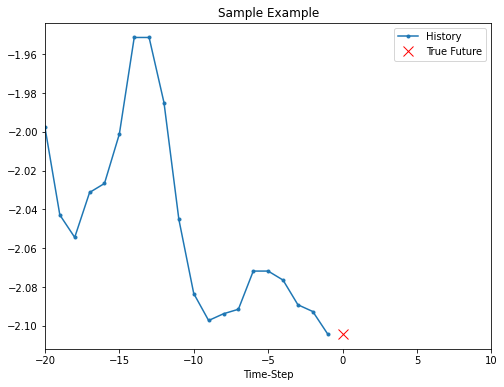

In [ ]:
"""
print(x_train_uni[0].shape) # (20, 1)
# () 裏面都是空的，因爲就是一個int值而已，連序列都不是
# 換句話說，必須至少是有2個值以上的序列，才能讓()裏面不爲空
print(y_train_uni[0].shape) 
print(y_train_uni.shape) # (299980,)
"""

# 乍看之下不理解show_plot()，那就直接丟數據觀察回傳
# 發現show_plot(plot_data, delta, title)，就是show_plot(歷史數據的藍色點連成線, 未來回歸的紅色label點或線趨勢, 圖名稱)
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 最差也得比平均强吧

In [ ]:
# 要看自己的方法好不好，要和別人做比較，常用的就是以經典model爲baseline，看和它們比的話，好多少
# 而在還沒學經典model之前，一般最簡單的預測，就是取平均值，或是中位數了
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

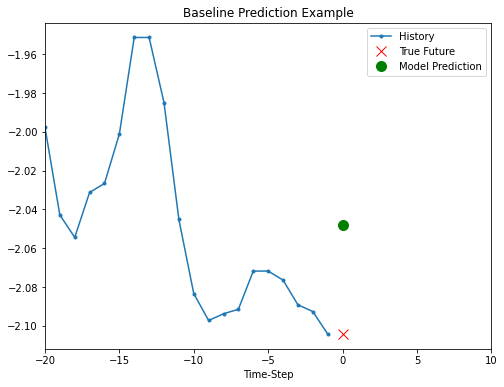

In [ ]:
# show_plot([歷史記錄序列, 未來某時間的氣溫實際值, 歷史記錄序列的平均值baseline], 是要預測距離現在多少個的未來時間序, 圖名稱)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')

### 构建RNN模型进行预测

In [ ]:
# 因為這個氣溫數據比較小，不是什麼圖片或大文本集合，所以BATCH_SIZE可以設大一點
# 在训练集中取batchsize个样本做一次iteration
BATCH_SIZE = 256
BUFFER_SIZE = 10000 # 為了之後要做shuffle()

# 先經由univariate_data()，把csv的資料做成dataset形式的(x_data, y_label)
# 然後再由Dataset.from_tensor_slices()，建構成tf用的資料集格式
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# 因為訓練集數據不大，所以要做repeat，那就會重複同樣資料的I/O，所以用cache()來減少這些I/O時間
# 第一次迭代數據集時，其元素將緩存在指定文件或內存中，隨後的迭代將使用緩存的數據
# 必須對輸入數據集進行「整體」迭代。否則，後續迭代將不會使用緩存數據。
# 緩存到文件時，緩存的數據將在運行中持續存在，即使是數據的第一次迭代也會從緩存文件中讀取
# 在刪除緩存文件或更改文件名之前，調用cache(同儲存位置)去修改原緩存數據將會無效。
# 每次迭代期間，將產生完全相同的元素。如果您希望隨機化迭代順序，請確保在調用後調用shuffle
# shuffle的BUFFER_SIZE是強迫要指定的，反正不要給一個太小的值就對了，太大則會佔用太多記憶體
# 對訓練集數據去做定版的操作：資料用緩存cache增加處理速度、
# shuffle把各筆(data, label)數據打亂之後、把這個大資料集去切batch、
# 然後repeat重複多次這樣的資料集，才可以跑多次epoch訓練
# 1个iteration等于使用batchsize个样本训练一次
# 1个epoch等于使用训练集中的全部样本训练一次
# 將tf格式的Dataset，去做cache().shuffle().batch().repeat()，是一種定版的操作
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# 驗證集就不需要shuffle()，反正丟進去全部跑一遍，出來個計算結果而已
# 驗證集需要做repeat嗎？如果需要，那應該就要用cache()啦，但這邊又沒有。所以是不是寫錯，多寫了repeat()啊？
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
# 因為repeat()括號內是空的，所以代表會無限的repeat下去，那有多少batch就也無所謂了，所以None
train_univariate
# <RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take
# take()也就是要取用多少個batch，而一個batch就是多筆(data,label)的意思
# 那一個batch的團體，不就等同也是一個dataset嗎，所以take()的回傳仍然是dataset
# 而對dataset做print，只會得到<Dataset...，或是<RepeatDataset...，或是<TakeDataset
# 因為dataset很大，所以不可能印出來，所以只會秀出這個dataset裡面裝有的資料格式而已
# 因為迭代是一種切分細項去執行的方式，所以可以利用for之類的迭代
# 去對這種大東西切細之後，那就有辦法print出來，看dataset裡面的東西了
# 對train_univariate取一個batch，所以(data, label)會是
# (<batch_size=256, 時序資料長度=20, 時序資料維度=1)>, <batch_size=256, label的資料維度)>)
# 如果label的資料維度為1，那就會被省略

for i,j in train_univariate.take(1):
    print(i.shape) # (256, 20, 1)
    print(j.shape) # (256,)
    
"""
for i in train_univariate.take(1):
    print(i)
# (<tf.Tensor: shape=(256, 20, 1), dtype=float64, numpy=
# array([[[-1.26358801],...[-1.28095571]]])>, 
# <tf.Tensor: shape=(256,), dtype=float64, numpy=
# array([-0.81318556,...,-1.26706155])>)
"""

(256, 20, 1)
(256,)


'\nfor i in train_univariate.take(1):\n    print(i)\n# (<tf.Tensor: shape=(256, 20, 1), dtype=float64, numpy=\n# array([[[-1.26358801],...[-1.28095571]]])>, \n# <tf.Tensor: shape=(256,), dtype=float64, numpy=\n# array([-0.81318556,...,-1.26706155])>)\n'

In [ ]:
# 要使用model之前，都需要先清楚model的input_shape格式，所以也必須去了解到訓練資料的shape
# 比如 LSTM 需要的是 (長度：序列有多少個時間步長, 維度：一個時間步長有多少個特征)
# 而train_univariate是由(x_train_uni, y_train_uni)做成的dataset
# 所以這樣dataset的x_train.shape，不含batch，就是我們要輸入的shape
# x_train_uni.shape # (299980, 20, 1)
# x_train_uni.shape[:] # (299980, 20, 1)
# x_train_uni.shape[-2:] # (20, 1)


LSTM模型

In [ ]:
# 建一個很簡單的Sequential的model，只放入LSTM()，然後接上Dense去做輸出就好了
simple_lstm_model = tf.keras.models.Sequential([
    # 因為數據量不大，任務也不難，所以指定8個隱層神經元夠用了，或是大點小點都可以
    # 參考RNN文本的輸入：(batch, 句子words數長度, word維度)
    # 輸入(batch：有多少個序列窗格, 長度：序列有多少個時間步長, 維度：一個時間步長有多少個特征)
    # 輸出(batch：多少個序列窗格, 維度：LSTM神經元數)
    # 這邊結構model而已，還沒有輸入dataset的數據
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1) # 因爲輸出只有1個氣溫值
])

# 建完model的結構之後，就是選擇損失函數、選優化器，然後做compile
# 回歸常用的損失函數: 平均絕對值誤差(Mean absolute error，MAE)、均方根誤差(Root Mean square error，RMSE)
# https://pythontechworld.com/article/detail/KVruVBsI6XsF
# rmse=np.sqrt(mean_squared_error(test_predict,test_y))
# mae = mean_absolute_error(y_pred=test_predict,y_true=test_y)
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error
# tf.keras.metrics.mean_absolute_error(y_true, y_pred)
# loss = mean(abs(y_true - y_pred), axis=-1)
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# 將 tf.data.Dataset傳遞給 fit 的x參數，這實際上不僅會產生特徵 (x)
# 其中可選的第二個和第三個元素將分別用於 y 和 sample_weight
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
# model.fit()是訓練模型用的，model.predict()是利用模型進行預測
# 所以在執行model.fit()的時候，才會是真正去應用，選用的optimizer、loss的時刻
# 也就是說，y_pred是順著網路架構前向傳遞後的結果
# 而要和y_pred去比較計算的y_true，是model.fit(dataset,...)，dataset當中的y_label
# simple_lstm_model.fit(train_univariate,...)，也就是，train_univariate當中的y_train_uni 
# 所以指定了loss='mae'，就知道去哪裡抓y_pred以及y_true的數值
# 來計算loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)了
simple_lstm_model.compile(optimizer='adam', loss='mae')

得到一个batch的测试结果

In [ ]:
# https://blog.csdn.net/tszupup/article/details/85275111
# predict()方法进行预测时，返回值是数值，表示样本属于每一个类别的概率
# predict()結果可以使用numpy.argmax()方法，找到样本以最大概率所属的类别，作为样本的预测标签
# predict_classes()方法进行预测时，返回的是类别的索引，即该样本所属的类别标签。
# 對驗證集取得一個batch的資料，回傳的(data, label)會是
# (<batch_size=256, 時序資料長度=20, 時序資料維度=1)>, <batch_size=256, label的資料維度)>)
# 因爲label的資料維度為1，所以會被省略。如果要保留，可以做reshape
# 或是在制做(x_train_uni, y_train_uni)的時候，就增加這個reshape的參數可選，然後default設置label的資料維度為1時不增加維度
# 至於(x_train_uni, y_train_uni)怎麼制作，這邊是使用自定義函數univariate_data()

"""
(csv -> df['xx'].values -> array)
從csv中只取出df的values部分，變成array的type，然後制作成dataset
array = df['T (degC)'].values
(array -> split -> array_train、array_vali)
把輸入array做切分，基本上是以左爲訓練集，右爲驗證集，所以設置一個外部可改的常量SPLIT
做數據標準化，因爲驗證集要保持不動，所以對array的mean、std都只要計算訓練集的部分
array_train_mean = uni_data[:SPLIT].mean()
array = (array - array_train_mean) / array_train_std
(array -> dataset)
輸出相關的參數有：窗口長度x_len、預測長度y_len
此外，因爲不一定都要把array的左邊部分當訓練集，右邊當驗證集，所以加設置了start、end這兩個參數，當做array的邊界，去加工成dataset
x, y = univariate_data(array, SPLIT, x_len, y_len)
因爲最後要return的dataset形態會是(np.array(data), np.array(labels))，所以設定
data=[], labels=[]
然後經由for去迭代，定下窗口的長度x_len、步長1，窗格一直步進右移
一個個把窗口內的x值加進去，同理把y值也加入labels的list中
x的特征如果是單維純量，那在加進去之前，要先做reshape多增加一個維度
這是因為要用什麼model，就要轉成搭配的input_shape
而這邊要用LSTM的架構，所以那就要仿照詞向量的多維特征
x, y = univariate_data(array, start, end, x_len, y_len)
"""

for x, y in val_univariate.take(1): 
    # val_univariate是一個dataset，也就是驗證集
    # 從 TRAIN_SPILIT = 300000，以及窗格時序長度 history_size = 20，一個時序中的特征維度只有單一的溫度值
    # 可以知道 x_train_uni.shape -> (299980, 20, 1)
    # 因為之前在做train和vali的dataset時，都有做batch(256)
    # 所以有滿batch的每一個take(最後一個batch可能不滿256)
    # 都會有256筆(x_data, y_label)
    # x_data -> (batch=256, 窗格時序長度20, 一個時序有1個特征維度)
    # y_label -> (batch=256, 一個未來的溫度氣溫值)
    print(x.shape) # (256, 20, 1)
    print(y.shape) # (256,)
    # models.Sequential最後是Dense(1)的輸出，所以(batch=256, 1)
    # 如果take(最後一個batch)，那batch可能就不足256了
    print(simple_lstm_model.predict(x).shape) # (256, 1) 
    # 回傳出256個預測，每個預測中有一個氣溫值
    # 所以證實dataset.take(1)會取到1個batch的數據量沒錯

(256, 20, 1)
(256,)
(256, 1)


为了训练的能快点，一个epoch就训练200次

In [ ]:
# 這邊把可修改的常數變數，設成大寫來提高識別度
# 因為只是先拿單特征來練手，確定目前的架構跑得起來就達到目的了
# 所以為了不改上面的code，但又想要只訓練部分數據就好，那就設個小數值的steps_per_epoch
# 只使用大約1/6的數據資料量，然後重複訓練10次
# https://its201.com/article/Hodors/97498168
# steps_per_epoch: 一个epoch包含的步数（每一步是一个batch的数据送入）
# 所以一個epoch有幾個steps，白話文就是一個epoch會跑幾個batch
# 默认的None代表自动分割，即数据集样本数/batch样本数
# 200(steps_per_epoch)*256(batch_size) ~= 5萬(数据集样本数) < 30萬(train_univariate的資料量)
# Epoch 1/10 200/200 [==============================] - 5s 15ms/step
# 總共要跑10個epoch，每一個epoch需要200個steps才能跑完
# 每隔一step跑一个batch=256個数据，所以一個epoch跑的資料量是200*256~=5萬
# 5萬(實際訓練样本数) / 30萬(擁有的可訓練資料量) = 1/6
# validation_steps=50，是steps_per_epoch=200的1/4，所以大約拿13000筆資料做驗證

EVALUATION_INTERVAL = 200
EPOCHS = 10

# steps_per_epoch指示在單個epoch，從生成器獲取batch的次數
# steps_per_epoch，一個epoch會跑幾個steps
# validation_steps，一個epoch结束时验证集生成器产生的步数
# 所以validation_steps和steps_per_epoch是一樣的意思，只是一個是驗證集，一個是訓練集
# validation_steps：模型应使用验证数据集运行多少个验证步骤
# https://jjzhou012.github.io/blog/2020/01/27/summary-problem-Keras-on-GNNs.html
# validation_steps：设置了验证使用的validation data steps数量(batch数量)，
# 应该不超过 TotalvalidationSamples / ValidationBatchSize
# 建议使用整个验证集用于验证，如果验证数据集很大，可以设置固定大小的validation_steps=10
# 则在10个验证batch后，计算损失平均值给出结果。
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

"""
訓練集從loss: 0.4071，降低到loss: 0.0228
驗證集從loss: 0.1303，降低到loss: 0.0176
訓練集、測試集的loss，都有在穩定下降，所以OK

Epoch 1/10
200/200 [==============================] - 5s 15ms/step - loss: 0.4071 - val_loss: 0.1303
...
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0228 - val_loss: 0.0176
"""

Epoch 1/10
200/200 [==============================] - 10s 27ms/step - loss: 0.4071 - val_loss: 0.1303
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1119 - val_loss: 0.0355
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0488 - val_loss: 0.0283
Epoch 4/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0444 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0318 - val_loss: 0.0233
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0287 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0261 - val_loss: 0.0195
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0253 - val_loss: 0.0187
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0228 - val_l

'\n訓練集從loss: 0.4071，降低到loss: 0.0228\n驗證集從loss: 0.1303，降低到loss: 0.0176\n訓練集、測試集的loss，都有在穩定下降，所以OK\n\nEpoch 1/10\n200/200 [==============================] - 5s 15ms/step - loss: 0.4071 - val_loss: 0.1303\n...\nEpoch 10/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0228 - val_loss: 0.0176\n'

In [ ]:
"""
Epoch 1/10
200/200 [==============================] - 5s 14ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0227 - val_loss: 0.0174
<keras.callbacks.History at 0x7f0867638110>
"""

'\nEpoch 1/10\n200/200 [==============================] - 5s 14ms/step - loss: 0.4075 - val_loss: 0.1351\nEpoch 2/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.1118 - val_loss: 0.0359\nEpoch 3/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - val_loss: 0.0290\nEpoch 4/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0443 - val_loss: 0.0258\nEpoch 5/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0299 - val_loss: 0.0235\nEpoch 6/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0317 - val_loss: 0.0224\nEpoch 7/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0286 - val_loss: 0.0207\nEpoch 8/10\n200/200 [==============================] - 2s 11ms/step - loss: 0.0263 - val_loss: 0.0197\nEpoch 9/10\n200/200 [==============================] - 2s 12ms/step - loss: 0.0253 - val_loss: 0.0181\nEpoch 10/10\n200/200 [==============================] - 2s 12ms/step -

### 用训练好的模型预测结果

展示其中部分数据的预测结果

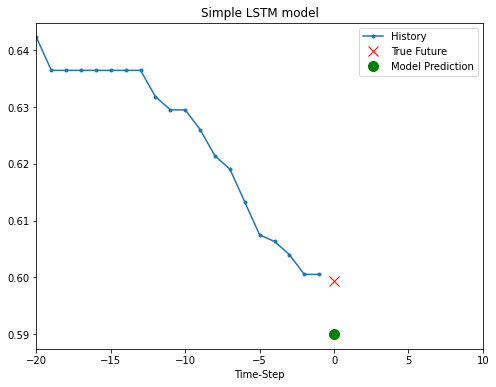

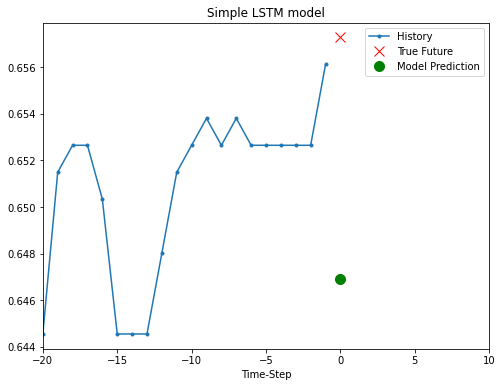

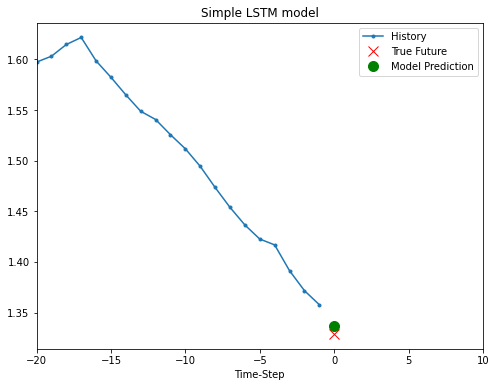

In [ ]:
# 從驗證集取前3個batch中的第一個時序窗格，畫出圖來看看成果
# dataset的回傳，會是(x_data, y_label)
for x, y in val_univariate.take(3): 
    # print(type(x)) # EagerTensor
    # print(type(y)) # EagerTensor
    # print(x.shape) # (256, 20, 1)
    # print(y.shape) # (256,)
    # print(x[0].numpy().shape) # (20, 1)
    # print(y[0].numpy().shape) # ()
    # print(simple_lstm_model.predict(x).shape) # (256, 1) 
    # print(simple_lstm_model.predict(x)[0].shape) # (1,)，取出第0個batch的shape
    # print(simple_lstm_model.predict(x).shape[0]) # 256，如果寫成這樣，那就變成是要知道predict結果的shape，shape中的第0個值
    # 雖然前面都是直接show_plot()就可以秀出圖了
    # 不然這邊是一次畫3筆資料，所以如果直接用show_plot()來秀，那3筆資料會在同一張圖
    # 但因為在show_plot()中，True Future和Model Prediction的marker是有設定，固定下來的
    # 所以在這3筆資料的線條名稱都是同樣，分不出True Future和Model Prediction
    # 各是哪一個History走勢對應到的未來預測值
    # 換句話說，如果沒有設定marker，雖然還是在同一張圖中，但至少線條marker會自動不撞色，可以勉強辨識
    # 這時候就顯示出show_plot()需要回傳plt的重要性了，也就是回傳matplotlib.pyplot
    # 因為回傳了plt，所以可以使用show_plot.show()，這樣一來就會分開做出3張圖
    # show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    # show_plot的第一個參數plot_data是繪圖的資料來源基礎，現在來源有3筆，所以用[]傳入給參數plot_data
    # dataset.take(3)，就是跑3次batch的意思
    # 所以每經過一次for，就會取出當筆take中的第0筆(x_data, y_label)
    # 在shwo_plot()中，依照plot_data的index順序，使用for給定了labels、marker的設定
    # 而labels的順序是['History', 'True Future', 'Model Prediction']
    # 也就是說，labels和maker的長度都是3，所以如果plot_data給了4筆資料，那就會找不到匹配的lables、marker，而報error
    # 從take取出的x、y，其shape分別是(256, 20, 1)、(256,)
    # 在第一個for當中，代表第一個batch
    # x[0]，代表取這個batch中的第一個時序窗格，也就是20個歷史氣溫值
    # y[0]，代表在這個batch中的第一時序窗格後，取時序偏差delta=0位置的未來氣溫值
    # 時序偏差delta=0位置，就是在歷史氣溫窗格後，緊接著的那個溫度
    # simple_lstm_model.predict(x)，代表將第一個batch送去給model訓練的回傳值
    # 而model結尾是Dense(1)，輸出一個未來溫度
    # 並且因為送進去batch有256筆歷史溫度，所以回傳值也會有256個未來溫度預測，shape是(256, 1)
    # simple_lstm_model.predict(x)[0]代表的是，這個batch中的第一筆未來溫度預測值
    # x[0]、y[0]是從tf的take()來的，所以是個EagerTensor，要用numpy()轉成np，才可以符合plt的輸入格式去畫圖
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()
    # 初步看起來，只抓單特征的預測結果不是那麼好，可能也和沒有用到所有可訓練的資料
    # 因為本來就預期要用多特征才有可能準，所以這個單特征的訓練，只是確定跑起來沒問題而已

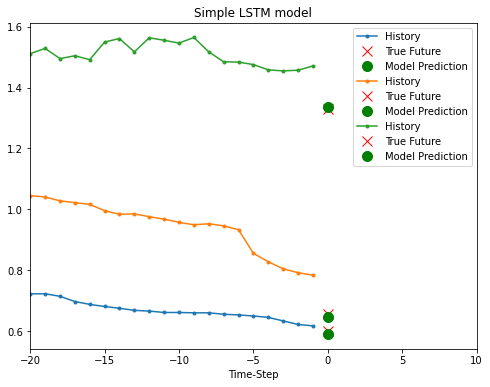

In [ ]:
# 如果直接用show_plot()來秀，那3筆資料會在同一張圖
# 如果take(4)，那就會是取前4個batch的第一個時序窗格
# 畫出他們的各自的'History', 'True Future', 'Model Prediction'
for x, y in val_univariate.take(3): 
    show_plot([x[135].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')

有的还凑合，有的差的比较多

### 多用些特征看看效果

In [ ]:
# 本來只有考慮歷史氣溫，現在連氣壓、空氣比重都考慮進來，特征的維度變成3維
# 可以類比想象成，詞向量有50維度，現在天氣則有3個維度
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [ ]:
# df['p (mbar)', 'T (degC)', 'rho (g/m**3)'] 會出現KeyError
# 因為df取值接收的是一個[],所以如果有多個值，就要先用[]包起來再傳入df去搜尋
# 就像如果要餵一個參數給函數，但那個參數裡面包含了3個值 def func(a,b=xxx,c=xxx)
# 就會用 func((a1,a2,a3)) 的方式包起來傳入
# 如果df只用一個[]，但裡面有逗號，那接收的方式就會是[rows_index, column_index]

# df是從csv讀進來的原檔
features = df[features_considered]
features.index = df['Date Time'] # 不改index也可以，那default就會0~N
features.head(5) # 同features[:5]


,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [ ]:
"""
Date Time	p (mbar)	T (degC)	rho (g/m**3)
01.01.2009 00:10:00	996.52	-8.02	1307.75
01.01.2009 00:20:00	996.57	-8.41	1309.8
01.01.2009 00:30:00	996.53	-8.51	1310.24
01.01.2009 00:40:00	996.51	-8.31	1309.19
01.01.2009 00:50:00	996.51	-8.27	1309.0
Show 25 per page
Like what you see? Visit the data table notebook to learn more about interactive tables.
"""

'\nDate Time\tp (mbar)\tT (degC)\trho (g/m**3)\n01.01.2009 00:10:00\t996.52\t-8.02\t1307.75\n01.01.2009 00:20:00\t996.57\t-8.41\t1309.8\n01.01.2009 00:30:00\t996.53\t-8.51\t1310.24\n01.01.2009 00:40:00\t996.51\t-8.31\t1309.19\n01.01.2009 00:50:00\t996.51\t-8.27\t1309.0\nShow 25 per page\nLike what you see? Visit the data table notebook to learn more about interactive tables.\n'

Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8563aa750>,
      dtype=object)

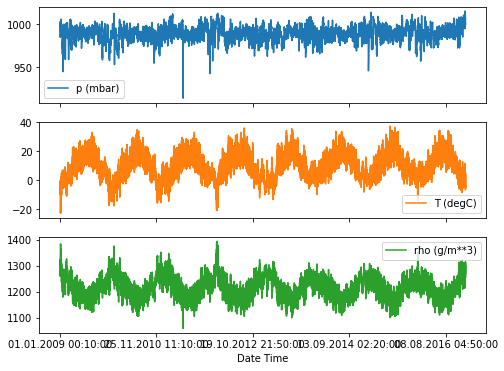

In [ ]:
# features是原始df，取出的3個columns
# 去看這3個特征是不是也有時間規律性
# df.plot()會把df.index當做x軸，df.values[i]當做y，df.columns[i]當做label
# default是subplots=False，也就是所有資料都畫在同一張圖上
# 所以如果想要各別column畫在各別圖上，那就要設subplots=True
# plt.plot()裡面不能設subplots
# 雖然都叫plot()，但一個是plt實例下的方法，一個是df實例下的方法，參數完全不同
features.plot(subplots=True)

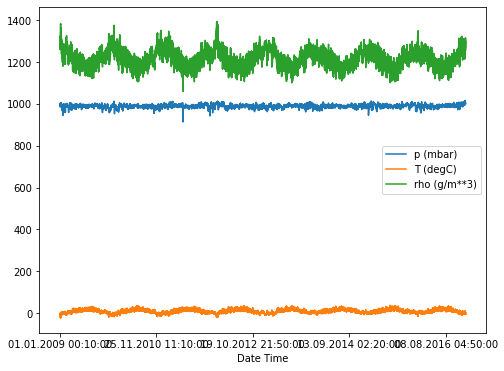

In [ ]:
# default是subplots=False，也就是所有資料都畫在同一張圖上
features.plot(subplots=False)

标准化的时候只能用训练数据

In [ ]:
# dataset.shape # (420551, 3) -> (index, columns)
# type(dataset) # numpy.ndarray
# 從index、col來看，二維的array，也許和df很類似
# 訓練資料只要是有序的輸入就好，不需要index的名字
# 捨棄index，從DataFrame變成numpy.ndarray
dataset = features.values 
# array([[ 996.52,   -8.02, 1307.75],
#        ...,
#        [ 999.82,   -4.82, 1296.38]])


# df[int1, int2]，[]裡面都是int，而且只有一個逗號，那就是指定index、col
# df[int1:int2]，[]裡面都是int，但不是一個逗號，那就是指定index（的所有col）
# df['string1','string2']，裡面都是string，那就是指定col（的所有index）


# array_2d[:4]，[]裡面都是int，但不是一個逗號，所以是指定index（的所有col）
# array_2d[0:4,0:]，[]裡面都是int，而且只有一個逗號，所以是指定index、col
# 也就是指定，0:4的index中的（所有的col）
# 所以雖然dataset[:4]的結果，剛好同dataset[0:4,0:]
# 但一個是指定index，一個是指定index、col，2者來源的意義不同
dataset[:4] 
# array([[ 996.52,   -8.02, 1307.75],
#        [ 996.57,   -8.41, 1309.8 ],
#        [ 996.53,   -8.51, 1310.24],
#        [ 996.51,   -8.31, 1309.19]])

array([[ 996.52,   -8.02, 1307.75],
       [ 996.57,   -8.41, 1309.8 ],
       [ 996.53,   -8.51, 1310.24],
       [ 996.51,   -8.31, 1309.19]])

In [ ]:
# df的axis=0是對那一個column做操作
# 因為axis=0必然是default，而default代表常用的操作
# 而df常用的操作，column絕對比index多太多了
# 所以對df來說，axis=0是column
# 但對於series來說，column就只有一個，所以series[]要指定的就只能是index
# dataset[:300000] 裡面都是int，但不是一個逗號，所以是指定index（的所有col）
# 也就是等同 dataset[0:300000, 0:]
# 不能寫dataset[0:300000,0:-1]，因為300000和-1都是開區間，是不會被包含進去的
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0) # 把到TRAIN_SPLIT之前的dataset，做平均
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
# 減掉平均，然後再除以標準差，就是簡單的 數據歸一化了
# 歸一化對訓練集做就好了
dataset = (dataset-data_mean)/data_std

### 时间窗口数据制作
- 只预测接下来一个时间点的结果

In [ ]:
# 因為這邊要使用csv中多個column來當特征，所以是多變量multivariate 
# 與單變量的univariate_data(dataset, start_index, end_index, history_size, target_size)相比
# 多了target、step、single_step，這3個參數
# step，是當數據變化不大時，可以設大一點的值來跳選，減少數據的計算量
# single_step，是和輸出有關，看是要輸出未來那個時間點的值就好（True）
# 還是直到那個時間點的區段值都要（default）
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    # 之所以需要start_index，是因為如果訓練集是從資料頭的索引0開始的某一個前段
    # 那對驗證集來說，就是資料中剩下的後段，而開始位置的索引就是start_index
    # 因為這邊對start_index的用法是，窗格從後面往前推算，
    start_index = start_index + history_size
    if end_index is None: # 注意！None不是用等於，而應該是用is
        end_index = len(dataset) - target_size

    # 5天*24小時*10分鐘1次=720 rows
    # 因為短時間的數據變化不大，所以多加了一個step的參數來跳選
    # 比如1小時內的6次只挑選1個，那數據的計算量，瞬間就只下降到1/6
    for i in range(start_index, end_index):
        # 就是在做indices的時候，要多一個step的參數去選擇
        # 其實step嘛，就會聯想到是在range裡面，所以只要到單特征函數
        # 去找哪裡有range，然後加上去就好了
        # 索引为range(0, 720, 6)，range(1, 721, 6) range(2, 722, 6)
        indices = range(i-history_size, i, step) 
        data.append(dataset[indices])


        if single_step: # 未來某個時間點，所以用+
            # 72是因為12小時*一小時6次
            # 這邊的start_index和end_index，已經是指時序窗格最末端的右邊那個位置了
            # 加號是指定要append，與當前時間有delta偏差時序，的那個時間點而已
            # 在univariate_data()中，是用labels.append(dataset[i+target_size])
            # 所以差別在，uni用dataset，而multi用target
            # 之所以有這個差別，是因為單特征中，data和label都是溫度，所以只有1個column，像是series
            # 但在多特征的中，dataset = features.values，values有3個columns
            # 所以本來的append(dataset[索引範圍])，就變成append(dataset[索引範圍, 1])
            # 但如果把3特征再擴展到5特征，或者氣溫不是放在features[:, 1]的欄位時，這個function就不能用了
            # 所以這邊才會多一個target的參數，增加function的泛化能力
            # 讓user自己指定氣溫是在features.values的哪一個欄位，比如第2個col，那就是 dataset[:, 1]
            labels.append(target[i+target_size]) #（720+72）（721+72）
        else: # 未來某個時間區段，所以用:
            # 冒號是指定要append，從當前時間，到有delta偏差時序，的那段時間點
            labels.append(target[i:i+target_size])
            # labels是個list，而target[...]也是個list
            # labels中的元素是list，所以轉成np.array()後，看起來有2層[]

    return np.array(data), np.array(labels) # 要做大量數據處理的話，都處理成numpy最好

- 选择训练窗口为5天的数据，5  * 24 乘 6=720条记录
- step=6表示每6隔6个时间点实际取一次数据，即窗口大小：720/6=120 ，索引为range(0, 720, 6)，range(0, 720, 6)
- 要预测的结果（标签）为12小时后的温度值，即12*6=72,72个时间点后的结果

In [ ]:
past_history = 720 # 选择训练窗口为5天
future_target = 72 # 要预测的结果（标签）为12小时后的温度值
# 數據處理的意義，step值就是資料壓縮比例
# 物理上的意義，因為溫度變化沒那麼劇烈，不需要那麼精細，所以step值可以稍大
# 數學上的意義，1小時取1次就好了，不需要10分鐘取1次
STEP = 6 

# 先和之前單特征的預測做比較，所以這邊設single_step為True，預測某一個時間點，而不是時間區段
# multivariate_data(dataset, target, start_index, end_index, history_size,
#                       target_size, step, single_step=False)
# history_size就是窗格長度，target_size則是與窗格末端右側的delta時序距離
# target就是實際的True溫度值，也就是y_label
# dataset是很多很多筆的(x_data, y_label)，可以想象成一大張df
# 去看features.head()就知道
"""
				    	p (mbar)	T (degC)	rho (g/m**3)
Date Time			
01.01.2009 00:10:00	    996.52  	-8.02   	1307.75
"""
# 而dataset = features.values，所以dataset[:, 1]就是指氣溫
# single的意思就是，輸出的預測只有單個值，而不是一段時間
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1],
                                                   0, TRAIN_SPLIT, 
                                                   past_history, future_target, 
                                                   STEP, single_step=True)

# if end_index is None: end_index = len(dataset) - target_size
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None,
                                               past_history, future_target,
                                               STEP, single_step=True)

数据维度

In [ ]:
# (299280, 120, 3)
# (299280筆時間序列窗口, 每個時間序列窗口長度為120個時間步長, 每個時間步長的特征是3維)
# 以前的詞向量是50維，而這邊的3維是1個時間下的溫度，由3個特征變因去控制
# 所以類推到詞向量的話，就代表一個詞用50個特征變因去控制
# 因為多了可以跳選的step，所以120的時間序列，不一定代表120/6=20小時哦！
x_train_single.shape

(299280, 120, 3)

In [ ]:
# (299280,) -> (batch,) 每筆data的shape沒寫，就代表是只有1個值而已
# 因為是single，所以輸出只有單個值
y_train_single.shape

(299280,)

### 构建训练数据

In [ ]:
# multivariate_data()返回的是np.array，並非Dataset的type
# 所以我們必須用from_tensor_slices()，把np.array建成標準的Dataset
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
# 而Dataset的定版操作就是，Dataset.cache().shuffle().batch().repeat()
# 因為資料量大，所以短暫的I/O的時間會被放大，所以要使用cache()，在快處理完的時候，就開始讀下一筆資料
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
# 驗證集、測試集，不用數據歸一化，也不用shuffle洗牌，原原本本的就好了
# 驗證集、測試集的資料量沒那麼大，所以I/O沒被放大的那麼嚴重，就不用cache()來提前佔用記憶體
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
train_data_single
# <RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
# 一長段的東西，就拆分成單元來看
# RepeatDataset：代表有沒有對原始資料集做Repeat()，還是Take()
# element_spec=()：看裡面有幾個元素。通常是2個Tensor，也就是(data, label)
# 而每一個Tensor裡面，Spec會有shape、dtype、name
# 不過shape裡面的batch都會顯示None，不知道是不是因為無限的repeat下去，所以有多少batch就也無所謂了，才顯示None

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# 取名叫single_step，可能是因爲Sequential()裏面至於一層LSTM而已吧
# shape要flatten拉平成1維，Dense函數才接收的了
# 所以顯然的，LSTM的輸出，會是一維
single_step_model = tf.keras.models.Sequential()
# 建一個Sequential()類的物件，然後用add()一一加入layers
# 因為現在輸入數據比單特征還大，所以隱層神經元也從8拉升到32
# 下一行縮排的話，就是比上一行(的位置，還有再多一個空格
# 要指定input_shape的話，用[-2:]之類的方式也可以，可讀性就比較明確，知道shape是要取幾個值
# 像一看到[-3:]的話，就會直覺猜到：「哦~取3個值啊！那可能是圖像資料，因為還有通道」
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
# 網路架構訂好之後，就把loss、optimizer給compile進去
# LSTM這類的氣溫預測，如果最後的預測時間點氣溫，非常靠近實際值，而且時間區段的氣溫走勢，也極為貼近實際溫度線
# 我們視覺上覺得很準，而且預測走勢和實際溫度線的均方差數值很低，那就會覺得這是一個好的預測模型
# 所以不像是分類模型那樣，有明確的對與錯分類。時序預測看得是，均方差的數值越低越好，也就是一個範圍內的走勢差異。
# 所以如果用metrics=['accuracy']，這種能夠完全一致的對與錯分類的話，那對於有小數點的氣溫，準確度就只會一直得到0而已
# 所以既然已經選擇mae當做loss，那就不需要再設置metrics來去做評價標準了
# 平均绝对误差（MAE）是一种用于回归模型的损失函数。MAE 是目标变量和预测变量之间绝对差值之和
# 衡量的是一组预测值中的平均误差大小，而不考虑它们的方向
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
    # (batch, x的shape) (batch, y的shape)
    print(x.shape, y.shape) # (256, 120, 3) (256,)
    # 所以predict回傳的是(batch, label的shape)
    print(single_step_model.predict(x).shape) # (256, 1)

(256, 120, 3) (256,)
(256, 1)


In [ ]:
# modle建構、compile損失&優化器、fit開始訓練
# single_step_model是個只有一層LSTM+Dense做輸出的Sequancial()網路架構
# 通常model.fit()的回傳，叫做history，我自己的話，這邊可能會命名成history_SingleStep，因爲一看到開頭就比較容易聯想到
# 一個epoch，是指所有會跑到的訓練數據，都跑過一次。
# 一個steps_per_epoch，是指要跑多少個batch
# 而batch_size，則會從已經在train_data_single裏面做過batch(BATCH_SIZE)，所以可以取得到
# train_data_single是RepeatDataset，因爲是無限repeat下去，所以使用train_data_single.shape會出現error
# for x,y in train_data_single.take(1): print(x.shape, y.shape) # (256, 120, 3) (256,)
# 可以看到train_data_single的確是有batch_size的資訊沒錯，所以指定了epoch、steps_per_epoch，就夠了
# 如果資料集train_data_single沒有分batch的話，那也可以直接在model.fit()裏面設置batch_size=256的參數
# 如果資料集也沒做batch()，fit也沒指定batch_size=xx，那default就會是batch_size=None
# 那就是一筆資料就更新一次，這樣學習速度更新的太快，幅度會太大，而很難收斂
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50
                                            )
# Epoch 1/10 step 200/200 [==============================] - 24s 111ms/step - loss: 0.3090 - val_loss: 0.2647
# steps_per_epoch = EVALUATION_INTERVAL -> 200


# 如果拿掉validation，當然可以，那就是少了「val_loss: 0.2647」這個資訊
# Epoch 1/10 step 200/200 [==============================] - 27s 135ms/step - loss: 0.2339

Epoch 1/10
200/200 [==============================] - 26s 119ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2623 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2611 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2568 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2260 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2415 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2413 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2406 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 32s 159ms/step - loss: 0.2451 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 25s 126ms/step - l

In [ ]:
"""
Epoch 1/10
200/200 [==============================] - 29s 132ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 31s 153ms/step - loss: 0.2623 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 27s 137ms/step - loss: 0.2611 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2568 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2260 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2415 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2413 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 22s 111ms/step - loss: 0.2406 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 22s 111ms/step - loss: 0.2451 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2384 - val_loss: 0.2442
"""

'\nEpoch 1/10\n200/200 [==============================] - 29s 132ms/step - loss: 0.3090 - val_loss: 0.2647\nEpoch 2/10\n200/200 [==============================] - 31s 153ms/step - loss: 0.2623 - val_loss: 0.2421\nEpoch 3/10\n200/200 [==============================] - 27s 137ms/step - loss: 0.2611 - val_loss: 0.2448\nEpoch 4/10\n200/200 [==============================] - 22s 112ms/step - loss: 0.2568 - val_loss: 0.2447\nEpoch 5/10\n200/200 [==============================] - 22s 110ms/step - loss: 0.2260 - val_loss: 0.2368\nEpoch 6/10\n200/200 [==============================] - 22s 112ms/step - loss: 0.2415 - val_loss: 0.2658\nEpoch 7/10\n200/200 [==============================] - 22s 112ms/step - loss: 0.2413 - val_loss: 0.2565\nEpoch 8/10\n200/200 [==============================] - 22s 111ms/step - loss: 0.2406 - val_loss: 0.2381\nEpoch 9/10\n200/200 [==============================] - 22s 111ms/step - loss: 0.2451 - val_loss: 0.2480\nEpoch 10/10\n200/200 [==============================

### 训练结果展示

In [ ]:
# 先看函數名稱，猜測是拿來幹嘛用的 -> 再去看實際應用 -> 看輸入了哪些引數，才了解def這邊的參數代表的意義
def plot_train_history(history, title):
    # Training loss
    loss = history.history['loss']
    # Validation loss
    val_loss = history.history['val_loss']
    # 要知道epoch的話，去找values的長度就知道了
    epochs = range(len(loss))
    # https://blog.csdn.net/qq_33039859/article/details/79439534
    # acc = history.history['accuracy']  # new version => hist.history['accuracy'] 
    # val_acc = history.history['val_accuracy'] #=> hist.history['val_accuracy'] 
    # print('acc: ', acc)
    # print('val_acc: ', val_acc)

    # figure()創建畫布、plot()畫圖、legend()
    # legend()可以设置图例位置、边框顏色、文字等，比如去掉图例边框 plt.legend(loc='best',frameon=False)
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

dict_keys(['loss', 'val_loss'])


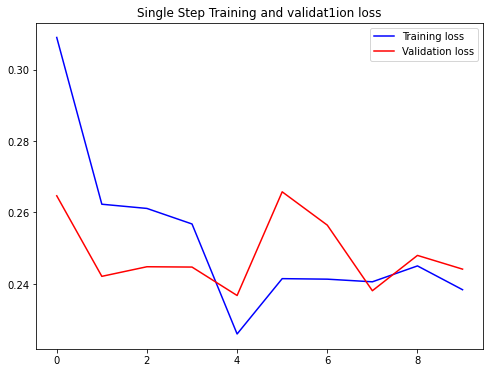

In [ ]:
# 對single_step_model.fit()的history，看裡面的結果有哪些keys
print(single_step_history.history.keys()) # dict_keys(['loss', 'val_loss'])
# 因爲只有設定loss='mae'，沒有設定而且也不能設定metrics='acc'(因爲氣溫是數值，要預測到數值完全一致，是不切實際的)，所以不會有acc的key

plot_train_history(single_step_history, # 就是model.fit()的history
                   'Single Step Training and validat1ion loss')

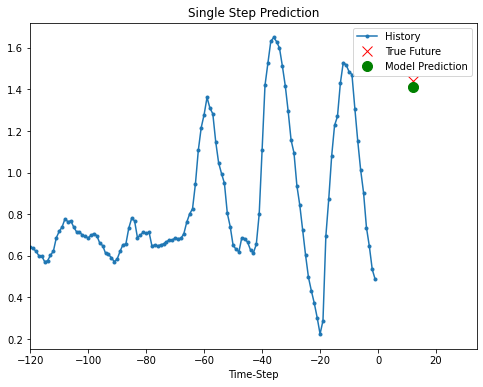

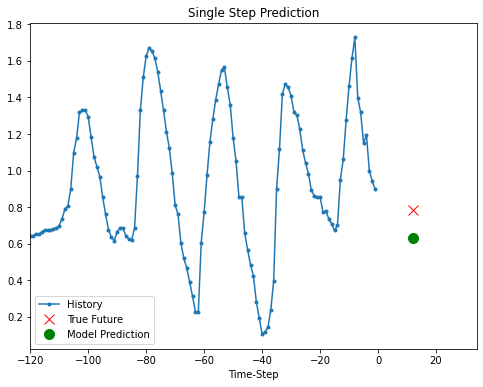

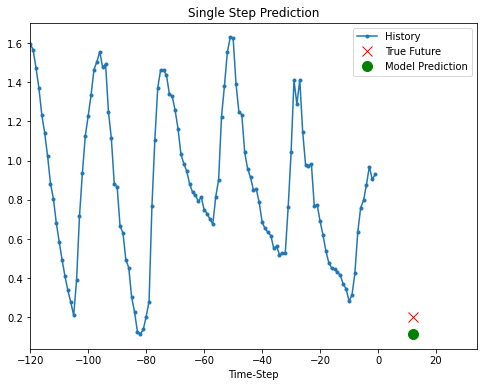

In [ ]:
for x, y in val_data_single.take(3): # 在驗證集中取出3個batch，並且用(x, y)來做解包
    # print(x.shape, y.shape) # (256, 120, 3) (256,)
    # x[0][:, 1].numpy()，在batch中取出第0筆資訊，對120個時間，從0～3的col中取出第1個col，也就是歷史氣溫值。然後轉成numpy才可以plot
    # y[0]，因爲label就只有單純的12小时後那個點的True氣溫而已
    # 因爲step=6代表1小時抽取1次記錄，future_target = 72代表12小時，single_step=True代表單點時間
    # show_plot([歷史記錄序列, 未來某時間的氣溫實際值, 歷史記錄序列的平均值baseline], 是要預測距離現在多少個的未來時間序, 圖名稱)
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()
    # 看起來還有一些差距，不過明顯已經比單特征好多了

### 预测接下来一个时间片段的结果

In [ ]:
future_target = 72
# multivariate_data()預設single_step=False，也就是預設輸出的是時間片段
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
# (299280, 120, 3)，120是每6次跳選1次
# 看到120不一定代表是1小時6次*20小時！有可能是因為數據密度太高，所以有跳選
x_train_multi.shape 
# (299280, 72)，除了batch外，還有別的數值，所以代表輸出不再是一個值
# 72個時間序列值，代表的是5天的區間
y_train_multi.shape 

(299280, 72)

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

要预测的序列

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    # 當下設爲時間0,所以歷史長度的數據，就要設爲負號時間，也就是range(-length, 0)
    # create_time_steps(8) # [-8, -7, -6, -5, -4, -3, -2, -1]
    num_in = create_time_steps(len(history)) # 輸入的history，其長度做range()就是x坐標，因爲是當作過去所以取負號
    num_out = len(true_future) # 輸入的true_future，其長度做range()就是x坐標，因爲是未來，所以取正號

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    # any(iterable) # 如果都为空、0、false，则返回false
    # np.array([0]) # [0]
    # any([0]) # False
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

(256, 120, 3) (256, 72)


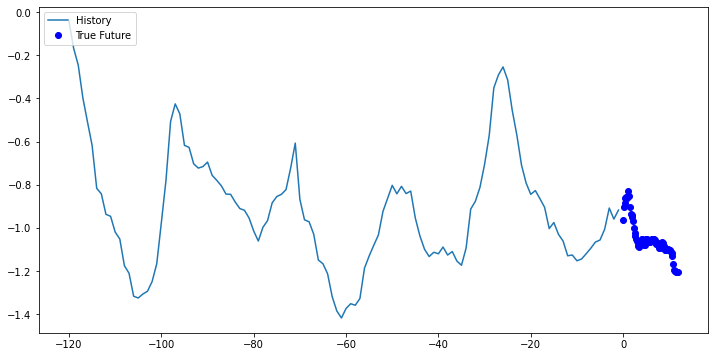

In [ ]:
for x, y in train_data_multi.take(1): # 假設這邊不小心多打了一個「1」
# 那就會在multi_step_plot(...)那顯示「unexpected indent」，然後怎麼查都不知道爲什麼
# 所以一旦發現error，除了上下行以外，也要看上一層、下一層
    # 因爲沒有prediction，所以隨便放個可迭代的object，比如list，然後裏面再放空元素/false/0之類的就好
    # 感覺應該在API就寫好default，不然誰會認真去看code，知道裏面是用any()實現，所以有上面這些放置的規定
    # (x, y) -> (data, label) 
    # x -> (batch_size, 時序窗格長度, 單一時序內的特徵)
    # 單一時序內的特徵 -> [氣壓、氣溫、空氣比重] -> ['p (mbar)', 'T (degC)', 'rho (g/m**3)'] 
    # print(x.shape, y.shape) # (256, 120, 3) (256, 72)
    # (這個batch中的第0筆data, 第0筆的label, 還沒有做prediction所以填個[0])
    # 因爲要畫圖，所以把可能會被認爲是tensor的[0]，轉成np的形式
    multi_step_plot(x[0], y[0], np.array([0]))

2层的LSTM网络，预测72个时间结果

In [ ]:
multi_step_model = tf.keras.models.Sequential()
# 因為後面要繼續接LSTM，所以返回必須是一樣長度的sequences，才符合後面LSTM的輸入shape，所以return_sequences=True
# 之前單特徵的時候，只給8個隱層神經元。現在有3個特徵，所以提高神經元數量
# 盡量主動給input_shape的話，避免自己搞不清楚到底是在處理怎樣的shape
# 資料.shape[-2:]很方便用，因爲如果沒有通道的話，最後2個就是資料的真正shape，前面可能有batch
# 換句話說，不管前面有沒有batch，都可以用[-2:]，所以用[-2:]很方便
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu')) # LSTM預設返回是一個結果值
# 所以雙層LSTM，後面那層的神經元，可能可以設爲前層的一半
multi_step_model.add(tf.keras.layers.Dense(72)) # 輸出的是72個時間序列區段值
# 神經網路自己不知道那72個值是要幹嘛的，反正就是要讓損失值越來越小，往那個目的方向去做的
# 所以dense輸出的72個值，要怎麼和時間序列區段做對應，重點在於損失函數的設計

# "clipnorm"(float) 按規範裁剪梯度；"clipvalue"(float) 按值剪輯漸變。
# SGD，是只對一個example的loss做計算
# Adagrad，每次更新的𝜂就是等於前一次的𝜂再除以𝜎^t
# RMSProp，比AdaGrad多了一個調整新舊gradient比重的參數
# Adam，就是加了momentum的RMSProp
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae') 

每个序列输入后都会得到72个预测结果

In [ ]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 43s 199ms/step - loss: 102379.5312 - val_loss: 1004949.4375
Epoch 2/10
200/200 [==============================] - 38s 192ms/step - loss: 16007850.0000 - val_loss: 0.3340
Epoch 3/10
200/200 [==============================] - 54s 268ms/step - loss: 0.3898 - val_loss: 0.2961
Epoch 4/10
200/200 [==============================] - 57s 286ms/step - loss: 0.2948 - val_loss: 0.2518
Epoch 5/10
200/200 [==============================] - 46s 229ms/step - loss: 0.2214 - val_loss: 0.2458
Epoch 6/10
200/200 [==============================] - 64s 318ms/step - loss: 0.2251 - val_loss: 0.2584
Epoch 7/10
200/200 [==============================] - 47s 234ms/step - loss: 0.2127 - val_loss: 0.1993
Epoch 8/10
200/200 [==============================] - 46s 228ms/step - loss: 0.2067 - val_loss: 0.2005
Epoch 9/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2104 - val_loss: 0.1946
Epoch 10/10
200/200 [==============================] - 

In [ ]:
"""
Epoch 1/10
200/200 [==============================] - 42s 193ms/step - loss: 0.4949 - val_loss: 0.3073
Epoch 2/10
200/200 [==============================] - 38s 189ms/step - loss: 0.3465 - val_loss: 0.2871
Epoch 3/10
200/200 [==============================] - 38s 190ms/step - loss: 0.3290 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 38s 188ms/step - loss: 0.2431 - val_loss: 0.2092
Epoch 5/10
200/200 [==============================] - 38s 190ms/step - loss: 0.1977 - val_loss: 0.1996
Epoch 6/10
200/200 [==============================] - 48s 240ms/step - loss: 0.2080 - val_loss: 0.2083
Epoch 7/10
200/200 [==============================] - 39s 193ms/step - loss: 0.1990 - val_loss: 0.2074
Epoch 8/10
200/200 [==============================] - 38s 192ms/step - loss: 0.1956 - val_loss: 0.1965
Epoch 9/10
200/200 [==============================] - 38s 191ms/step - loss: 0.1976 - val_loss: 0.1914
Epoch 10/10
200/200 [==============================] - 38s 191ms/step - loss: 0.1898 - val_loss: 0.1827
"""

'\nEpoch 1/10\n200/200 [==============================] - 42s 193ms/step - loss: 0.4949 - val_loss: 0.3073\nEpoch 2/10\n200/200 [==============================] - 38s 189ms/step - loss: 0.3465 - val_loss: 0.2871\nEpoch 3/10\n200/200 [==============================] - 38s 190ms/step - loss: 0.3290 - val_loss: 0.2466\nEpoch 4/10\n200/200 [==============================] - 38s 188ms/step - loss: 0.2431 - val_loss: 0.2092\nEpoch 5/10\n200/200 [==============================] - 38s 190ms/step - loss: 0.1977 - val_loss: 0.1996\nEpoch 6/10\n200/200 [==============================] - 48s 240ms/step - loss: 0.2080 - val_loss: 0.2083\nEpoch 7/10\n200/200 [==============================] - 39s 193ms/step - loss: 0.1990 - val_loss: 0.2074\nEpoch 8/10\n200/200 [==============================] - 38s 192ms/step - loss: 0.1956 - val_loss: 0.1965\nEpoch 9/10\n200/200 [==============================] - 38s 191ms/step - loss: 0.1976 - val_loss: 0.1914\nEpoch 10/10\n200/200 [==============================

### 预测结果展示

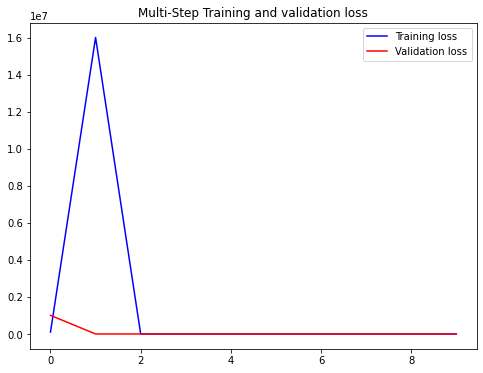

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

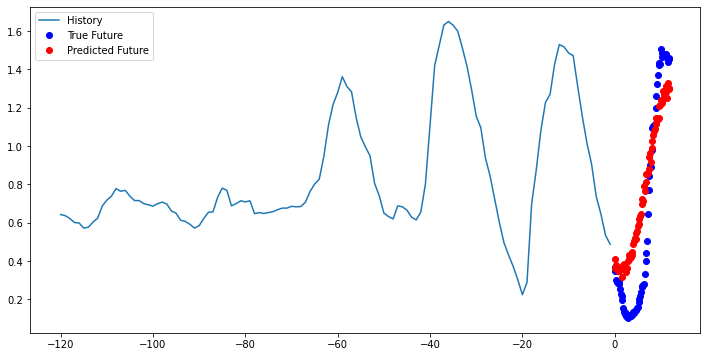

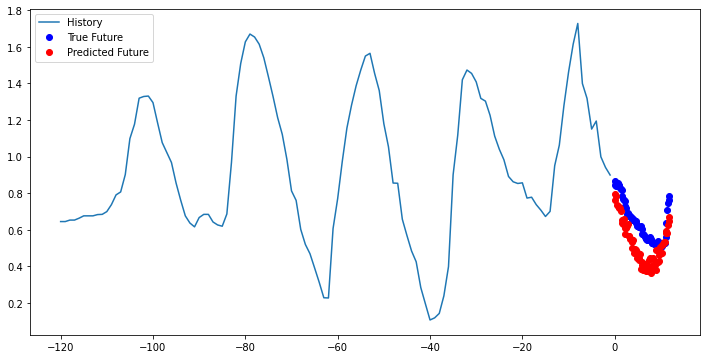

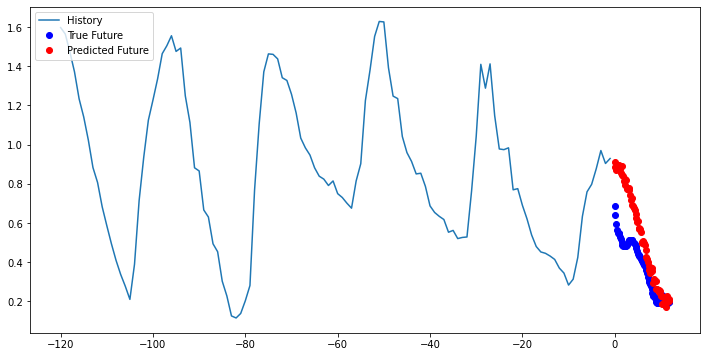

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
"""
https://www.ecloudvalley.com/zh-hant/machine-learning/

機器學習的種類最主要分成四種：

監督式學習（Supervised learning）、
非監督式學習（Un-supervised learning）、
半監督式學習（Semi-supervised learning）、
強化學習（Reinforcement learning）。

監督式學習（Supervised learning）：
所有資料都被「標註」(label)，告訴機器相對應的值，以提供機器學習在輸出時判斷誤差使用。這種方法為人工分類，對電腦來說最簡單，對人類來說最辛苦。這種方法像是告訴機器（電腦）標準答案，正式考試的時候機器依照標準答案作答，正確性會比較高。例如，若要訓練機器區分大象和長頸鹿，則提供機器 100 張大象和長頸鹿的照片。機器依照標註的照片去偵測大象和長頸鹿的特徵，依照特徵就能辨識出大象和長頸鹿並進行預測。


非監督式學習（Un-supervised learning）：
所有資料都沒有標註，機器透過尋找資料的特徵，自己進行分類。此種方法不用人工進行分類，對人類來說最簡單，但對電腦來說最辛苦，誤差較大。若使用非監督式學習辨識大象及長頸鹿，機器得自行判斷提供的 100 張照片裡有哪些特徵的是大象、哪些特徵的是長頸鹿並同時進行分類。在未來預測時，利用機器自行所分類的特徵去辨識是哪一種動物。但機器所辨識的結果不一定正確。


半監督式學習（Semi-supervised learning）：
對少部分資料進行「標註」，電腦只要透過有標註的資料找出特徵並對其它的資料進行分類。這種方法可以讓預測時比較精準，是目前最常用的一種方式。若有 100 張照片，則標註其中 10 張哪些是大象哪些是長頸鹿。機器透過這 10 張照片的特徵去辨識及分類剩餘的照片。因為已經有辨識的依據，所以預測出來的結果通常比非監督式學習準確。


強化式學習（Reinforcement learning）：
機器透過每一次與環境互動來學習，以取得最大化的預期利益。運用強化式學習的方式，我們不標註任何資料，但告訴它所採取的哪一步是正確、那一步是錯誤的，根據反饋的好壞，機器自行逐步修正、最終得到正確的結果。能使非監督式學習達成一定程度的正確性，就不能缺少強化式學習的方式。若機器自行辨識特徵與分類，將某張大象的照片預測成長頸鹿，則人類給予錯誤的訊息。機器會再次辨認特徵及分類。透過一次一次正確與錯誤的學習，最後的預測就會越來越精準。

"""

'\nhttps://www.ecloudvalley.com/zh-hant/machine-learning/\n\n機器學習的種類最主要分成四種：\n\n監督式學習（Supervised learning）、\n非監督式學習（Un-supervised learning）、\n半監督式學習（Semi-supervised learning）、\n強化學習（Reinforcement learning）。\n\n監督式學習（Supervised learning）：\n所有資料都被「標註」(label)，告訴機器相對應的值，以提供機器學習在輸出時判斷誤差使用。這種方法為人工分類，對電腦來說最簡單，對人類來說最辛苦。這種方法像是告訴機器（電腦）標準答案，正式考試的時候機器依照標準答案作答，正確性會比較高。例如，若要訓練機器區分大象和長頸鹿，則提供機器 100 張大象和長頸鹿的照片。機器依照標註的照片去偵測大象和長頸鹿的特徵，依照特徵就能辨識出大象和長頸鹿並進行預測。\n\n\n非監督式學習（Un-supervised learning）：\n所有資料都沒有標註，機器透過尋找資料的特徵，自己進行分類。此種方法不用人工進行分類，對人類來說最簡單，但對電腦來說最辛苦，誤差較大。若使用非監督式學習辨識大象及長頸鹿，機器得自行判斷提供的 100 張照片裡有哪些特徵的是大象、哪些特徵的是長頸鹿並同時進行分類。在未來預測時，利用機器自行所分類的特徵去辨識是哪一種動物。但機器所辨識的結果不一定正確。\n\n\n半監督式學習（Semi-supervised learning）：\n對少部分資料進行「標註」，電腦只要透過有標註的資料找出特徵並對其它的資料進行分類。這種方法可以讓預測時比較精準，是目前最常用的一種方式。若有 100 張照片，則標註其中 10 張哪些是大象哪些是長頸鹿。機器透過這 10 張照片的特徵去辨識及分類剩餘的照片。因為已經有辨識的依據，所以預測出來的結果通常比非監督式學習準確。\n\n\n強化式學習（Reinforcement learning）：\n機器透過每一次與環境互動來學習，以取得最大化的預期利益。運用強化式學習的方式，我們不標註任何資料，但告訴它所採取的哪一步是正確、那一步是錯誤的，根據反饋的好壞，機器自行逐步修正、最終得到正確的結果。能使非監督式學習達

In [ ]:
df = pd.DataFrame([[np.nan,33,55],range(3),[8,10,np.nan],range(3,6)])
#      0   1     2
# 0  NaN  33  55.0
# 1  0.0   1   2.0
# 2  8.0  10   NaN
# 3  3.0   4   5.0 

# axis=0是default，而會當做default的就代表比較常用
# 所以df的axis=0，指的會是column
df.mean(axis=0) # mean不把NaN也當做分母
# 0     3.666667
# 1    12.000000
# 2    20.666667
# dtype: float64

0     3.666667
1    12.000000
2    20.666667
dtype: float64

In [ ]:
#########################################################
"""
《dataset.take()》
https://www.gcptutorials.com/article/how-to-use-take-method-in-tensorflow

用於限制數據集中項目數量的方法。
如果使用的是較早版本的 TensorFlow，要啟用 Eager Execution 來運行代碼。

tensor1 = tf.range(5) # 創建Tensor
dataset = tf.data.Dataset.from_tensor_slices(tensor1) # 創建dataset
dataset = dataset.repeat(2).batch(batch_size=2)

for i in dataset:
    print(i)
# tf.Tensor([0 1], shape=(2,), dtype=int32)
# tf.Tensor([2 3], shape=(2,), dtype=int32)
# tf.Tensor([4 0], shape=(2,), dtype=int32)
# tf.Tensor([1 2], shape=(2,), dtype=int32)
# tf.Tensor([3 4], shape=(2,), dtype=int32)

for i in dataset.take(3):
    print(i)
# tf.Tensor([0 1], shape=(2,), dtype=int32)
# tf.Tensor([2 3], shape=(2,), dtype=int32)
# tf.Tensor([4 0], shape=(2,), dtype=int32)

"""
#########################################################

'\n《dataset.take()》\nhttps://www.gcptutorials.com/article/how-to-use-take-method-in-tensorflow\n\n用於限制數據集中項目數量的方法。\n如果使用的是較早版本的 TensorFlow，要啟用 Eager Execution 來運行代碼。\n\ntensor1 = tf.range(5) # 創建Tensor\ndataset = tf.data.Dataset.from_tensor_slices(tensor1) # 創建dataset\ndataset = dataset.repeat(2).batch(batch_size=2)\n\nfor i in dataset:\n    print(i)\n# tf.Tensor([0 1], shape=(2,), dtype=int32)\n# tf.Tensor([2 3], shape=(2,), dtype=int32)\n# tf.Tensor([4 0], shape=(2,), dtype=int32)\n# tf.Tensor([1 2], shape=(2,), dtype=int32)\n# tf.Tensor([3 4], shape=(2,), dtype=int32)\n\nfor i in dataset.take(3):\n    print(i)\n# tf.Tensor([0 1], shape=(2,), dtype=int32)\n# tf.Tensor([2 3], shape=(2,), dtype=int32)\n# tf.Tensor([4 0], shape=(2,), dtype=int32)\n\n'

In [ ]:
##########################################################
"""
《steps_per_epoch》
# https://keras.io/zh/models/sequential/
# 模型是從 initial_epoch（恢复之前的训练）的轮次开始训练，到第epochs轮次停止训练。
# 所以模型并不是训练了 epochs 轮，因為 initial_epoch 不一定為0
# steps_per_epoch是训练图像的数量除以批次大小。比如100张图像且批次大小为50，则值为2
# https://zhuanlan.zhihu.com/p/165188660
# 不同于fit()一次性加载所有的train数据集，遍历一遍（steps=1）就可以作为一轮epoch的结束
# generator是可以从给定的数据集中“无限”生成数据的
# 并且因为一次只加载数据集的一部分，解决数据集过大无法一次性加载到内存的问题
# 所以generator并不知道什么时候才是一轮epoch的结束
# batch_size也没有作为参数传递给fit_generator()，所以必须有机制来判断：
# (1)batch_size是多少 (2)什么时候结束一轮epoch
# steps_per_epoch 代表一轮epoch的结束，需要执行多少steps
# 比如全數據一次加載進去，那steps就等於1
# steps_per_epoch = len(x_train)/batch_size
# 对于整个训练数据集，generator要在多少步内完成一轮遍历（epoch）
# 从而也就规定了每步要加载多少数据（batch_size）

"""
##########################################################

'\n《steps_per_epoch》\n# https://keras.io/zh/models/sequential/\n# 模型是從 initial_epoch（恢复之前的训练）的轮次开始训练，到第epochs轮次停止训练。\n# 所以模型并不是训练了 epochs 轮，因為 initial_epoch 不一定為0\n# steps_per_epoch是训练图像的数量除以批次大小。比如100张图像且批次大小为50，则值为2\n# https://zhuanlan.zhihu.com/p/165188660\n# 不同于fit()一次性加载所有的train数据集，遍历一遍（steps=1）就可以作为一轮epoch的结束\n# generator是可以从给定的数据集中“无限”生成数据的\n# 并且因为一次只加载数据集的一部分，解决数据集过大无法一次性加载到内存的问题\n# 所以generator并不知道什么时候才是一轮epoch的结束\n# batch_size也没有作为参数传递给fit_generator()，所以必须有机制来判断：\n# (1)batch_size是多少 (2)什么时候结束一轮epoch\n# steps_per_epoch 代表一轮epoch的结束，需要执行多少steps\n# 比如全數據一次加載進去，那steps就等於1\n# steps_per_epoch = len(x_train)/batch_size\n# 对于整个训练数据集，generator要在多少步内完成一轮遍历（epoch）\n# 从而也就规定了每步要加载多少数据（batch_size）\n\n'

In [ ]:
##########################################################
"""
《__call__》
https://blog.csdn.net/dream_to_dream/article/details/115295662

class CLanguage:
    # 定义__call__方法
    def __call__(self,name,add):
        print("调用__call__()方法",name,add)
 
clangs = CLanguage()
clangs("C语言中文网","http://c.biancheng.net")
# 调用__call__()方法 C语言中文网 http://c.biancheng.net

__call__()是Python內建的私有方法，也就是在compiler中，
隱藏了某些自動的機制。而__call__內建私有函數的機制就是：

創建實例，通常是呼叫實例函數來做應用，
但如果有建立__call__方法，則可以直接呼叫實例名，
會自動去呼叫__call__()。

雙底線__xx__()函數具有自動執行特殊功能的能力，
比如__init__會自動創建物件屬性，
或是類似super()會一直往父類尋找。

雙底線函數__xx__()，當然也可以放參數，比如__init__(xx,...)。

"""
##########################################################

'\n《__call__》\nhttps://blog.csdn.net/dream_to_dream/article/details/115295662\n\nclass CLanguage:\n    # 定义__call__方法\n    def __call__(self,name,add):\n        print("调用__call__()方法",name,add)\n \nclangs = CLanguage()\nclangs("C语言中文网","http://c.biancheng.net")\n# 调用__call__()方法 C语言中文网 http://c.biancheng.net\n\n__call__()是Python內建的私有方法，也就是在compiler中，\n隱藏了某些自動的機制。而__call__內建私有函數的機制就是：\n\n創建實例，通常是呼叫實例函數來做應用，\n但如果有建立__call__方法，則可以直接呼叫實例名，\n會自動去呼叫__call__()。\n\n雙底線__xx__()函數具有自動執行特殊功能的能力，\n比如__init__會自動創建物件屬性，\n或是類似super()會一直往父類尋找。\n\n雙底線函數__xx__()，當然也可以放參數，比如__init__(xx,...)。\n\n'

In [ ]:
# 实际上"xx()"可以理解为是"xx.__call__()"的简写
def say():
    print("Python教程：http://c.biancheng.net/python")

say() # 其實就是say.__call__()的简写
# Python教程：http://c.biancheng.net/python
say.__call__() 
# Python教程：http://c.biancheng.net/python

Python教程：http://c.biancheng.net/python
Python教程：http://c.biancheng.net/python


In [ ]:
##########################################################
"""
《hasattr》
hasattr()函数的功能，是查找类的实例对象中是否包含指定名称的属性或者方法。
但该函数有一个缺陷，即它无法判断该指定的名称，到底是类属性还是类方法。

class CLanguage:

    def __init__ (self):
        self.name = "C语言中文网"
        self.add = "http://c.biancheng.net"

    def say(self):
        print("我正在学Python")
 
clangs = CLanguage()

if hasattr(clangs,"name"):
    print(hasattr(clangs.name,"__call__")) # False
    # name 是类属性，它没有名为 __call__() 的方法

if hasattr(clangs,"say"):
    print(hasattr(clangs.say,"__call__")) # True
    # say 是类方法，所以是可调用对象，因此有 __call__() 方法。

可调用对象包括函数类实例对象，凡是可以将 () 直接应用到自身并执行，都称为可调用对象。

"""
##########################################################

'\n《hasattr》\nhasattr()函数的功能，是查找类的实例对象中是否包含指定名称的属性或者方法。\n但该函数有一个缺陷，即它无法判断该指定的名称，到底是类属性还是类方法。\n\nclass CLanguage:\n\n    def __init__ (self):\n        self.name = "C语言中文网"\n        self.add = "http://c.biancheng.net"\n\n    def say(self):\n        print("我正在学Python")\n \nclangs = CLanguage()\n\nif hasattr(clangs,"name"):\n    print(hasattr(clangs.name,"__call__")) # False\n    # name 是类属性，它没有名为 __call__() 的方法\n\nif hasattr(clangs,"say"):\n    print(hasattr(clangs.say,"__call__")) # True\n    # say 是类方法，所以是可调用对象，因此有 __call__() 方法。\n\n可调用对象包括函数类实例对象，凡是可以将 () 直接应用到自身并执行，都称为可调用对象。\n\n'

In [ ]:
##########################################################
"""
《TensorFlow中call（）》
利用网络层类对象进行前向计算时，只需要调用类的 __call__ 方法即可，
在TensorFlow的框架中，已經設定好，写了model(x)，就會自动去调用类的 __call__ 方法，
然後在Python的__call__方法中，会自动再去调用TensorFlow的call()方法，
所以當我們在使用model(x)的時候，背後終極實現的，是TensorFlow中定義的call()方法，
所以我們只需要将网络层的前向计算逻辑，寫在call()裡面，那就是model(x)會呼叫的網路架構了。
 
class Network(keras.Model):
     # 回归网络模型
     def __init__(self):
         super(Network, self).__init__()
         # 创建 3 个全连接层
         self.fc1 = layers.Dense(64, activation='relu')
         self.fc2 = layers.Dense(64, activation='relu')
         self.fc3 = layers.Dense(1)
 
     def call(self, inputs, training=None, mask=None):
         # 依次通过 3 个全连接层
         x = self.fc1(inputs)
         x = self.fc2(x)
         x = self.fc3(x)
         return x
 
 
model = Network() # 创建网络类实例
# 通过 build 函数完成内部张量的创建，其中 4 为任意设置的 batch 数量，9 为输入特征长度
model.build(input_shape=(4, 9))
model.summary() # 打印网络信息
optimizer = tf.keras.optimizers.RMSprop(0.001) # 创建优化器，指定学习率
# 接下来实现网络训练部分。通过 Epoch 和 Step 组成的双层循环训练网络，共训练 200个 Epoch
for epoch in range(200): # 200 个 Epoch
    for step, (x,y) in enumerate(train_db): # 遍历一次训练集
        # 梯度记录器，训练时需要使用它
        with tf.GradientTape() as tape:
            out = model(x) # 通过网络获得输出
            loss = tf.reduce_mean(losses.MSE(y, out)) # 计算 MSE
            mae_loss = tf.reduce_mean(losses.MAE(y, out)) # 计算 MAE
        if step % 10 == 0: # 间隔性地打印训练误差
            print(epoch, step, float(loss))
    
        # loss值對於訓練變數model.trainable_variables的偏微分
        grads = tape.gradient(loss, model.trainable_variables) # 计算梯度
        # 將（計算出來的梯度，和訓練變數）做成元組，然後使用apply，對優化器進行數值的更新
        optimizer.apply_gradients(zip(grads, model.trainable_variables)) # 更新梯度

"""
##########################################################

"\n《TensorFlow中call（）》\n利用网络层类对象进行前向计算时，只需要调用类的 __call__ 方法即可，\n在TensorFlow的框架中，已經設定好，写了model(x)，就會自动去调用类的 __call__ 方法，\n然後在Python的__call__方法中，会自动再去调用TensorFlow的call()方法，\n所以當我們在使用model(x)的時候，背後終極實現的，是TensorFlow中定義的call()方法，\n所以我們只需要将网络层的前向计算逻辑，寫在call()裡面，那就是model(x)會呼叫的網路架構了。\n \nclass Network(keras.Model):\n     # 回归网络模型\n     def __init__(self):\n         super(Network, self).__init__()\n         # 创建 3 个全连接层\n         self.fc1 = layers.Dense(64, activation='relu')\n         self.fc2 = layers.Dense(64, activation='relu')\n         self.fc3 = layers.Dense(1)\n \n     def call(self, inputs, training=None, mask=None):\n         # 依次通过 3 个全连接层\n         x = self.fc1(inputs)\n         x = self.fc2(x)\n         x = self.fc3(x)\n         return x\n \n \nmodel = Network() # 创建网络类实例\n# 通过 build 函数完成内部张量的创建，其中 4 为任意设置的 batch 数量，9 为输入特征长度\nmodel.build(input_shape=(4, 9))\nmodel.summary() # 打印网络信息\noptimizer = tf.keras.optimizers.RMSprop(0.001) # 创建优化器，指定学习率\n# 接下来实现网络训练部分。通过 Epoch 和 Step 组成的双层

In [ ]:
"""
##########################################################
《各種優化器 - Optimizer》
https://medium.com/chung-yi/ml%E5%85%A5%E9%96%80-%E5%8D%81-gradient-descent-e97890236262

# learning rate
如果learning rate太大會造成波動非常大
反之，如果learning rate非常小，收斂得很慢。

# 梯度下降
從整個data set計算出梯度後，要朝著下降的方向前進
為了要最小化loss function，每次在執行梯度下降時，是非常消耗時間的事情
因為要朝著global minimun前進，就需要對整個data計算一次。

# SGD
隨機梯度下降法SGD，就是只對一個example的loss做計算，求梯度最小值。
看過棋靈王就會知道，假設今天有20筆資料
用梯度下降法去下圍棋，你必須考慮完這20筆資料才開始下第一步
但如果你用隨機梯度下降法，你已經下了二十步了

# Adagrad
Adagrad，就是每次更新的𝜂就是等於前一次的𝜂再除以𝜎^t
而 σ^t則代表的是第 t 次以前的所有梯度更新值之平方和開根號(root mean square)。
也就是Adagrad的更新幅度，會越來越小

# RMSProp
AdaGrad沿著同一個方向的梯度變化是非常大的
多了一個參數 𝛼，可以自由調整新舊gradient的比重（影響力）
每一次更新learning rate時，分母所除的σ都與前一次的有關係

# momentum 
momentum，它可以解決停在local minimum的問題
如圖所示，當球滾到最右邊的時候，gradient告訴我們的方向是往左
但如果真的往左，則可能會卡在local minmum的地方
如果加上momemtum是有可能可以往右前進，突破local minmum

# Adam
Adam其實就是加了momentum的RMSProp
Adam繼承兩者的優點，適合大部分的狀況，為目前最常使用的優化方法
##########################################################
"""